The purpose of this notebook is to reproduce the results Of
"Data-driven prediction of battery cycle life before capacity degradation" Severson, et al.  
(https://www.nature.com/articles/s41560-019-0356-8)

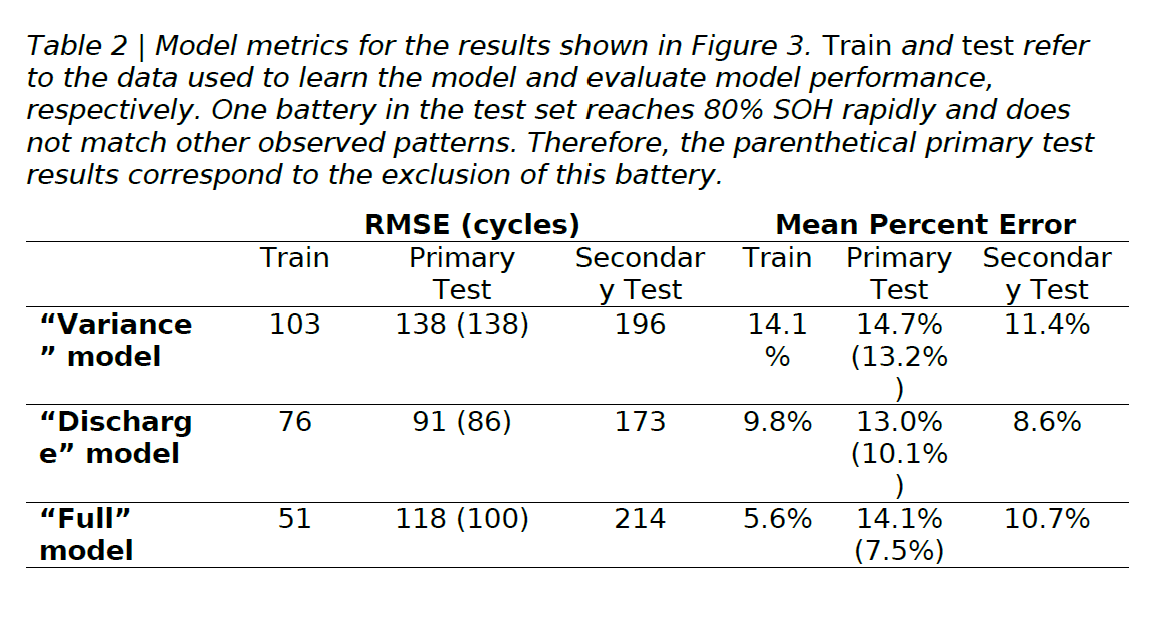

The data is Publicly available
(https://www.nature.com/articles/s41560-019-0356-8#data-availability)
https://data.matr.io/1/projects/5c48dd2bc625d700019f3204

The author provides data pre-processing code
(https://www.nature.com/articles/s41560-019-0356-8#code-availability)
https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation 

The Pre-processed data is a Dictionary With 4 keys: 


['cycle_life', 'charge_policy', 'summary', 'cycles'] 

    'cycle_life' An integer, and is the target of machine learning. 
    It is the number of cycles until the battery fails
    
    'summary' is a Nested dictionary with 8 keys:
    ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle']
        *The length of each of the 8 arrays is the cycle_life(int) Of the cell
        *Each value of The 8 arrays Correspondences to each cycle of the cell
    
    'cycles' is a Nested dictionary with cycle_life(int) number of keys:
    ['1', '2', … 'cycle_life'(int)]
        Each key In 'cycles' Is a nested dictionary with 8 keys:
        ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't']
             *The length of each of the arrays is the Length of time 't' of each cycle
             *With the exception of 'Qdlin' & 'Tdlin', Which is normalized to Array length 1000
             
#######
             
Feature engineering and Machine learning Model (ElasticNet) Was adapted from a GitHub repository that attempted to Reproduce the results of Severson, et al. I found several mistakes.
https://github.com/rochan17/Battery-Life-Prediction

Supplementary Information provided by Severson, et al.  
(https://www.nature.com/articles/s41560-019-0356-8#Sec10)
https://static-content.springer.com/esm/art%3A10.1038%2Fs41560-019-0356-8/MediaObjects/41560_2019_356_MOESM1_ESM.pdf

The final Pandas dataframe 'BatteryDataset.csv' Is Summary data for First 100 cycles 
Of each of the 124 battery cells And is to be used In follow-up notebook

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from scipy.stats import skew,kurtosis
from sklearn import preprocessing
from sklearn.linear_model import ElasticNet,LinearRegression,ElasticNetCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from  sklearn.model_selection import ShuffleSplit 

In [2]:
########################################
# Original data
# from https://data.matr.io/1/projects/5c48dd2bc625d700019f3204
########################################

matFilename1 = '2017-05-12_batchdata_updated_struct_errorcorrect.mat'
matFilename2 = '2017-06-30_batchdata_updated_struct_errorcorrect.mat'
matFilename3 = '2018-04-12_batchdata_updated_struct_errorcorrect.mat'

################################################################################

The following code is directly copied from the author's GitHubFor preprocessing the raw data

https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation

################################################################################

In [3]:
f = h5py.File(matFilename1)
batch=f['batch']
num_cells = batch['summary'].shape[0]
bat_dict = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b1c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict1 = bat_dict

#Batch2

In [4]:
f = h5py.File(matFilename2)
batch=f['batch']
num_cells = batch['summary'].shape[0]
bat_dict = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b2c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict2 = bat_dict

Batch 3

In [5]:
f = h5py.File(matFilename3)
batch=f['batch']
num_cells = batch['summary'].shape[0]
x=range(num_cells)
bat_dict = {}
for i in x:
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b3c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict3 = bat_dict

In [6]:
# Dictionary copies, to preserve batch_dict1,batch_dict2,batch_dict3
# And prevent having to rerun above code, In case of errors
batch1 = batch_dict1.copy()
batch2 = batch_dict2.copy()
batch3 = batch_dict3.copy()

In [7]:
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']#Corrected
del batch3['b3c43']#Corrected

numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3

In [8]:
bat_dict = {**batch1, **batch2, **batch3}
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30

Text(0, 0.5, 'Discharge Capacity (Ah)')

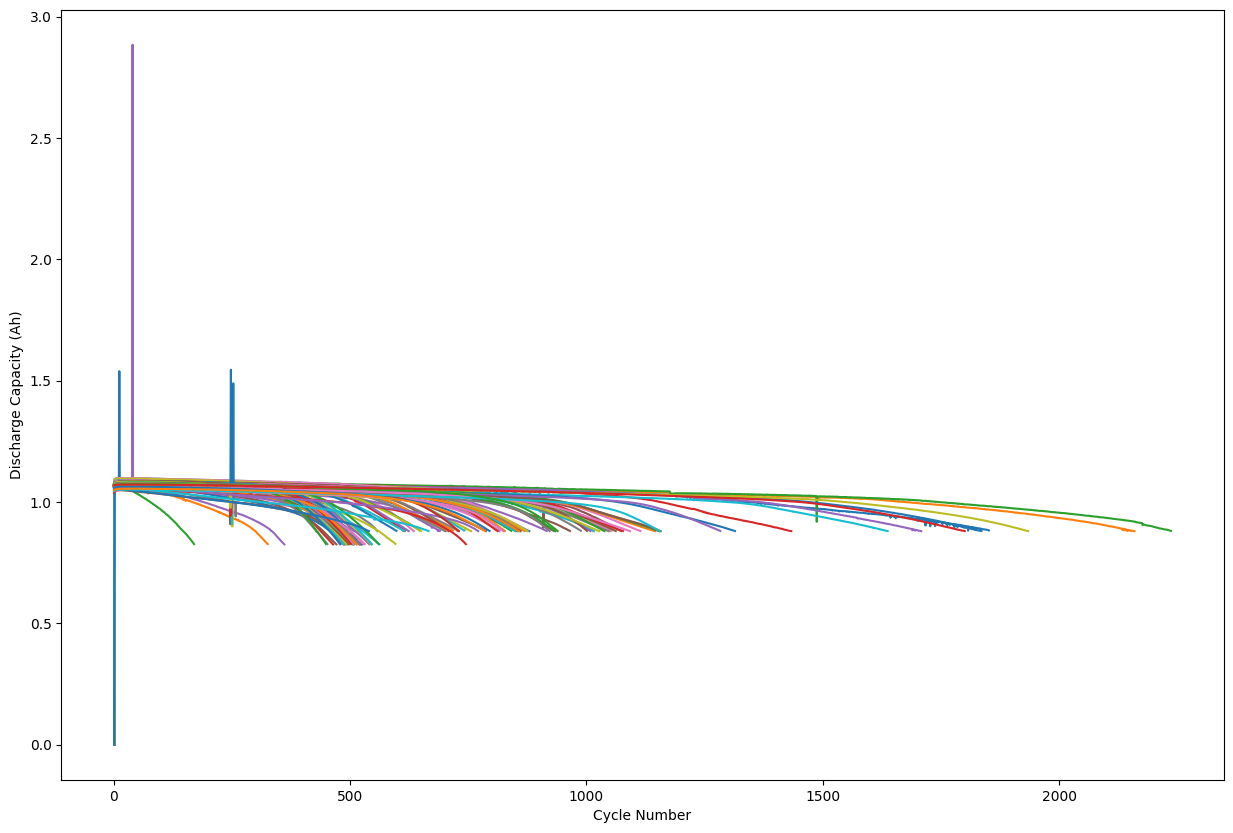

In [9]:
# Re-create figure 1a, Severson, et al.
plt.figure(figsize=(15,10))
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [10]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

In [11]:
print(test_ind)
print(train_ind)
print(secondary_test_ind)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 83]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81]
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123]


################################################################################

The Pre-processed data, bat_dict, is a Dictionary With 4 keys: 


['cycle_life', 'charge_policy', 'summary', 'cycles'] 


    'cycle_life' An integer, and is the target of machine learning. 
    It is the number of cycles until the battery fails

    'summary' is a Nested dictionary with 8 keys:
    ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle']
        *The length of each of the 8 arrays is the cycle_life(int) Of the cell
        *Each value of The 8 arrays Correspondences to each cycle of the cell

    'cycles' is a Nested dictionary with cycle_life(int) number of keys:
    ['1', '2', … 'cycle_life'(int)]
        Each key In 'cycles' Is a nested dictionary with 8 keys:
        ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't']
             *The length of each of the arrays is the Length of time 't' of each cycle
             *With the exception of 'Qdlin' & 'Tdlin', Which is normalized to Array length 1000

################################################################################

The following code creates a dataframe With the features and target for machine learning. Severson, et al.  Describes the features for 3 models in table 1 and further explanation of feature engineering is in Supplementary Note 1. (https://static-content.springer.com/esm/art%3A10.1038%2Fs41560-019-0356-8/MediaObjects/41560_2019_356_MOESM1_ESM.pdf)

################################################################################


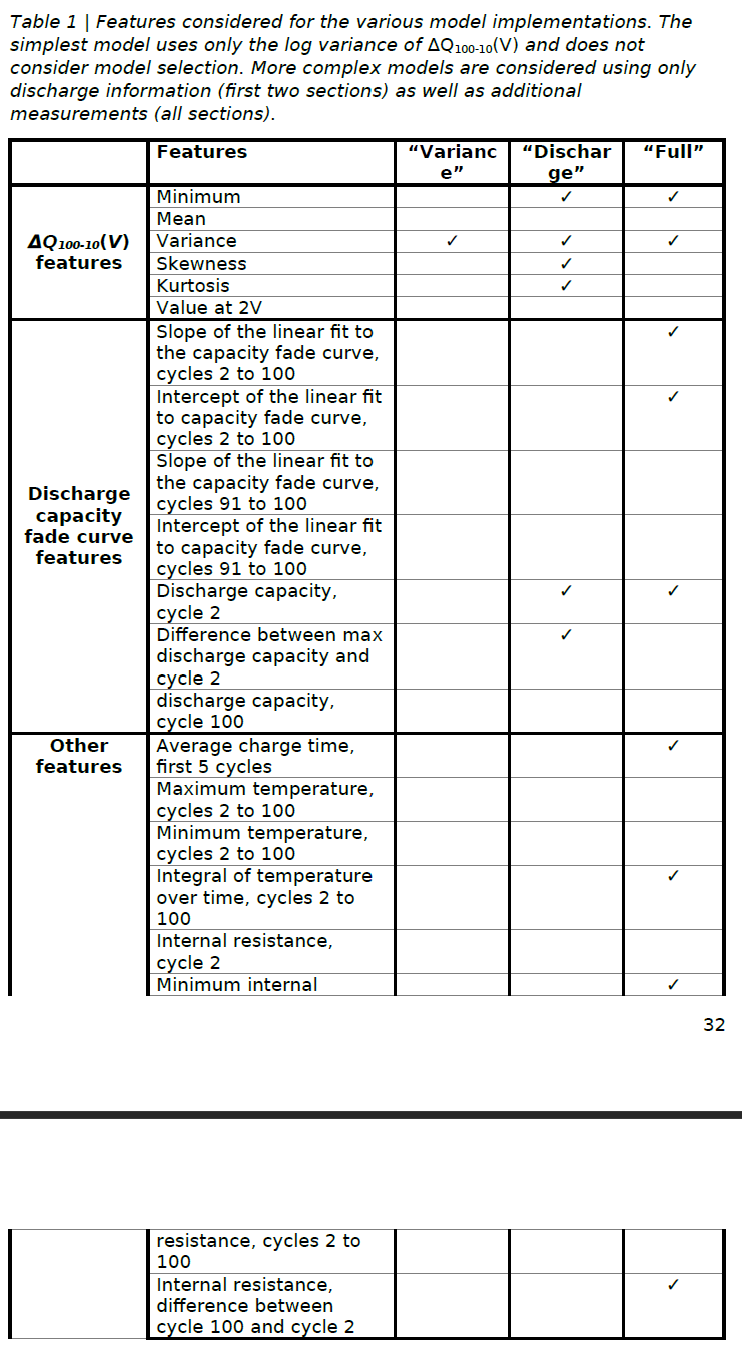

In [12]:
# Pandas Dataframe To hold all the features
dataset=pd.DataFrame()

# Battery cell Names from battery dictionary
dataset['cell']=bat_dict.keys()

# Number of cycles until battery reaches 80% capacity
# This is the target of the machine learning
############################################
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset['cell_life']=cl

In [13]:
# Numpy arrays to hold Each feature
minimum_dQ_100_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_100_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_100_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_100_10 = np.zeros(len(bat_dict.keys()))
mean_dQ_100_10 = np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_91_100=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_91_100=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Discharge_Cap_100=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_100=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_100=np.zeros(len(bat_dict.keys()))

This is all the feature engineering!
This is a potential source of Error
The features are on table 1
Supplementary Note 1. Feature formulations

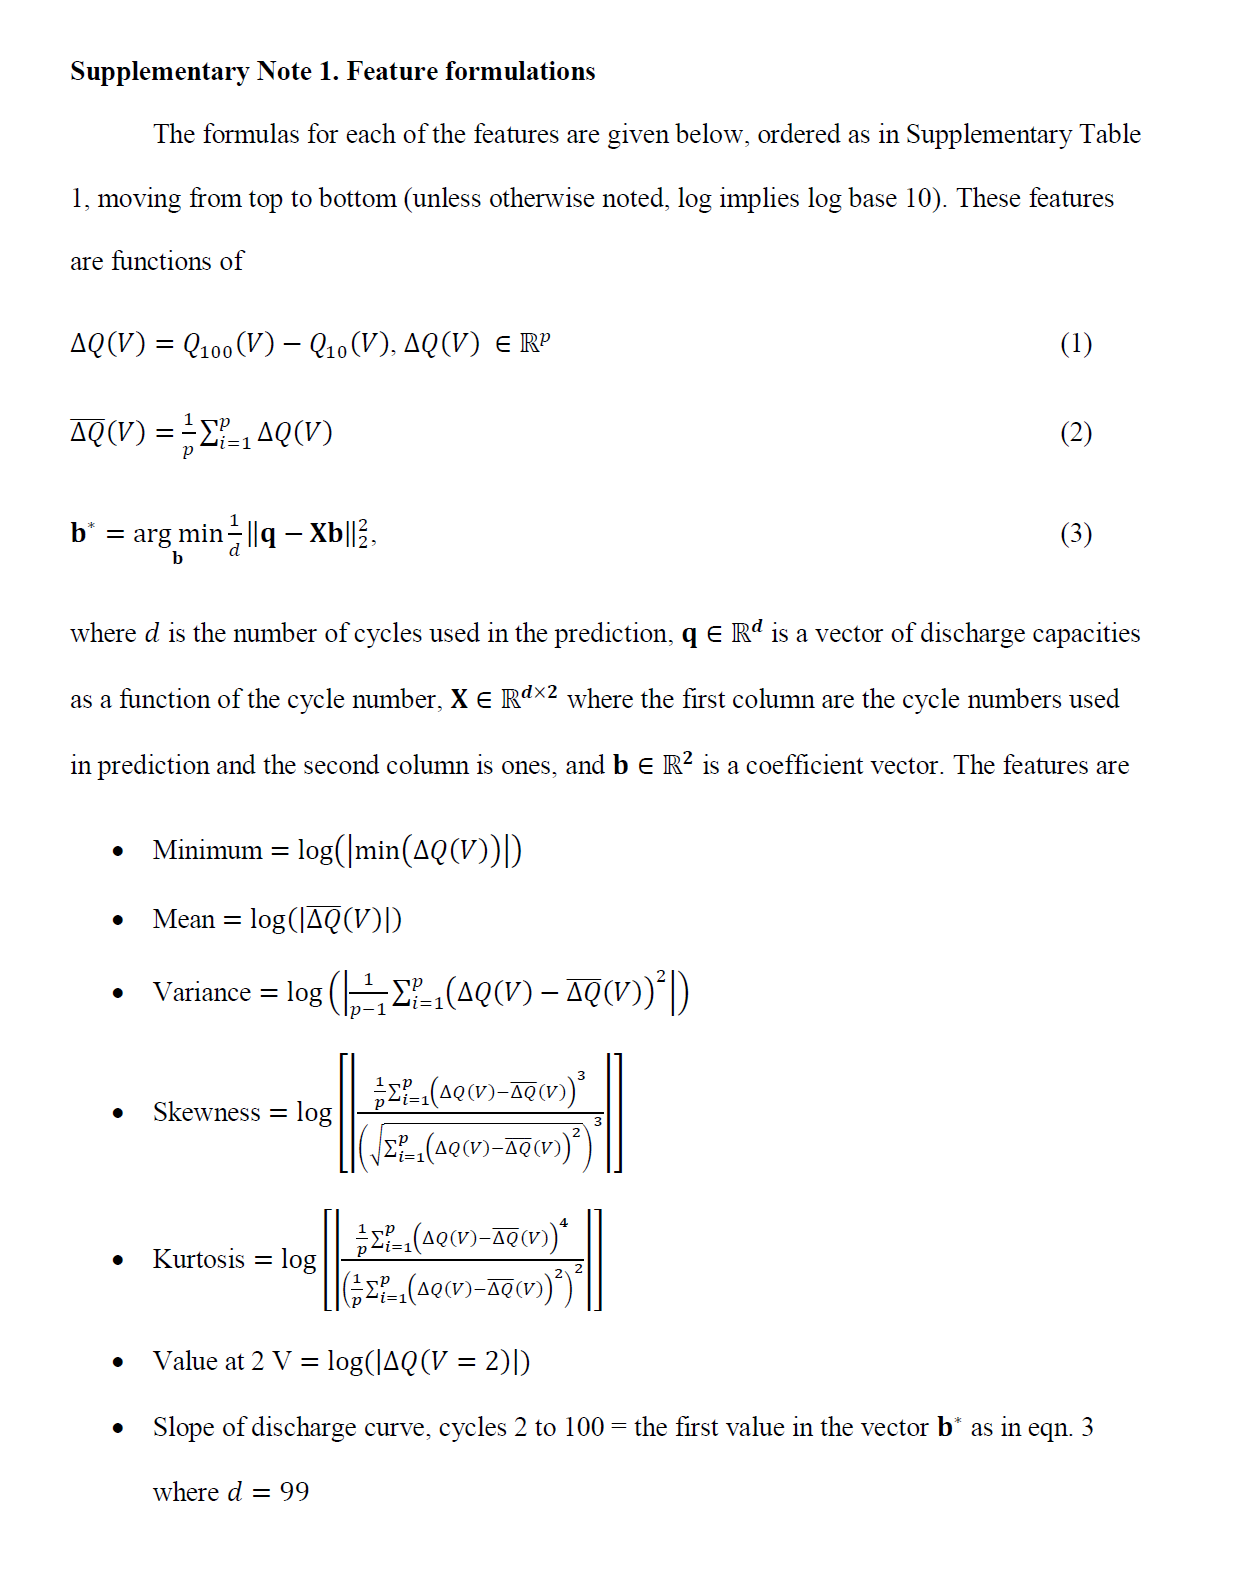

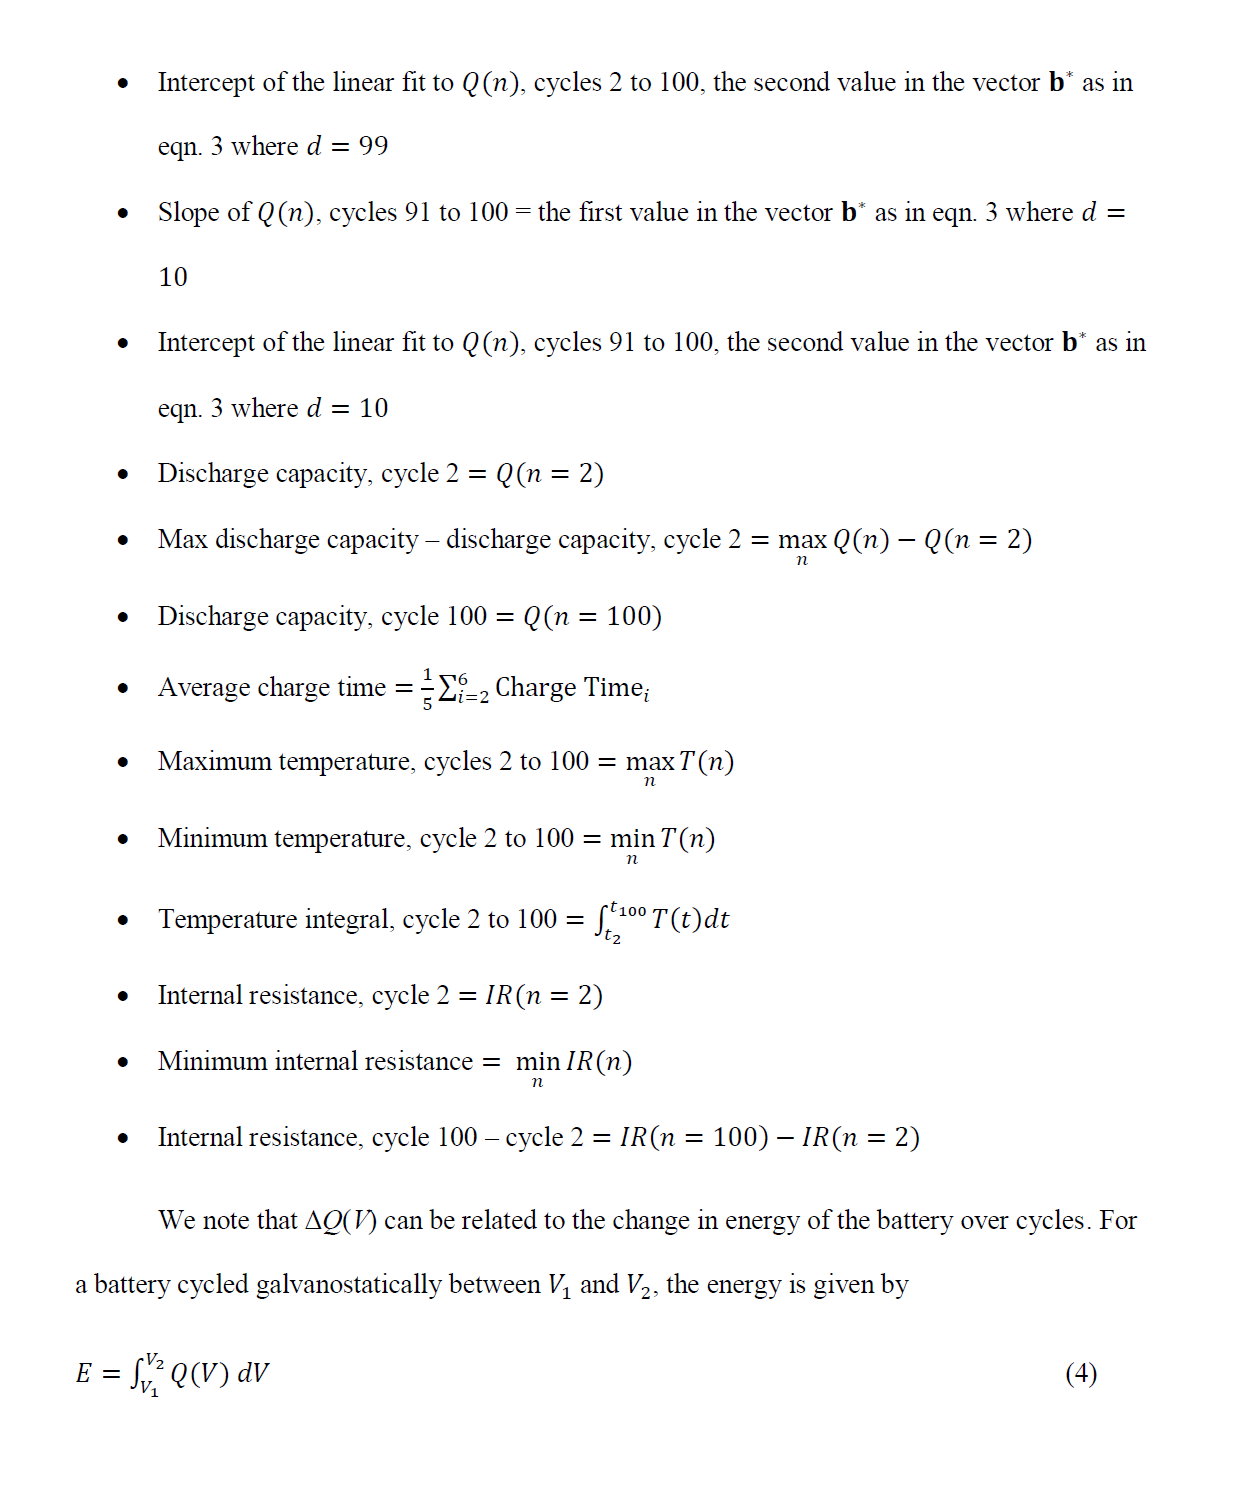

In [14]:
# Loop through battery dictionary and create features for machine learning
for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['9']#Corrected
    c100 = cell['cycles']['99']#Corrected
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    
    minimum_dQ_100_10[i] = np.log10(np.abs(np.min(dQ_100_10)))
    variance_dQ_100_10[i] = np.log10(np.var(dQ_100_10))
    skewness_dQ_100_10[i] = np.log10(np.abs(skew(dQ_100_10)))
    kurtosis_dQ_100_10[i] = np.log10(np.abs(kurtosis(dQ_100_10)))
    mean_dQ_100_10[i] = np.log10(np.abs(np.mean(dQ_100_10)))
    
    #Discharge Capacity Fade Curve Features
    dqall=cell['summary']['QD']
    cap=cell['summary']['QD'][1:100].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:100].reshape(-1,1)
    
    cap90=cell['summary']['QD'][90:100].reshape(-1,1)
    cycle90=cell['summary']['cycle'][90:100].reshape(-1,1)

    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    Slope_Cap_Fade_2_100[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_100[i]=regressor.intercept_
    
    regressor90=LinearRegression()
    regressor90.fit(cycle90,cap90)
    Slope_Cap_Fade_91_100[i]=regressor90.coef_[0]
    Intercept_Cap_Fade_91_100[i]=regressor90.intercept_
    
    Discharge_Cap_2[i]=cap[0][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[0][0]
    Discharge_Cap_100[i]=cap[98][0] 
    
    #Other features
    avg_time=np.mean(cell['summary']['chargetime'][1:6])#Corrected
    a=cell['summary']['chargetime'][1:100]
    b=cell['summary']['Tavg'][1:100]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:100]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][99]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_100[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_100[i]=IR_diff

In [15]:
# Insert numpy arrays into dataFrame
dataset['minimum_dQ_100_10']=minimum_dQ_100_10
dataset['variance_dQ_100_10']=variance_dQ_100_10 
dataset['skewness_dQ_100_10']=skewness_dQ_100_10 
dataset['kurtosis_dQ_100_10']=kurtosis_dQ_100_10 
dataset['mean_dQ_100_10']=mean_dQ_100_10 
dataset['Slope_Cap_Fade_2_100']=Slope_Cap_Fade_2_100
dataset['Intercept_Cap_Fade_2_100']=Intercept_Cap_Fade_2_100
dataset['Slope_Cap_Fade_91_100']=Slope_Cap_Fade_91_100
dataset['Intercept_Cap_Fade_91_100']=Intercept_Cap_Fade_91_100
dataset['Discharge_Cap_2']=Discharge_Cap_2
dataset['Discharge_Cap_100']=Discharge_Cap_100
dataset['Diff_MaxCap_DC2']=Diff_MaxCap_DC2
dataset['Avg_charge_time']=Avg_charge_time
dataset['Temp_Integ_2_100']=Temp_Integ_2_100
dataset['Min_IR']=Min_IR
dataset['Diff_IR_2_100']=Diff_IR_2_100 

Corrections found at https://www.dropbox.com/sh/rxeprl07xjj38sr/AABqO2uQQ5N3q4hcGyGPc_PAa?dl=0

In [16]:
dataset['Diff_MaxCap_DC2'][0] = 0.0064
dataset['Slope_Cap_Fade_2_100'][0] = 1.692e-5
dataset['Intercept_Cap_Fade_2_100'][0] = 1.0750
dataset['Diff_MaxCap_DC2'][14] = 0.00397
dataset['Slope_Cap_Fade_2_100'][14] = -4.8296e-5
dataset['Intercept_Cap_Fade_2_100'][14] = 1.0705

C:\Users\James\AppData\Local\Temp\ipykernel_2500\2805046988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Diff_MaxCap_DC2'][0] = 0.0064
C:\Users\James\AppData\Local\Temp\ipykernel_2500\2805046988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Slope_Cap_Fade_2_100'][0] = 1.692e-5
C:\Users\James\AppData\Local\Temp\ipykernel_2500\2805046988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Intercept

In [17]:
dataset.corr()

C:\Users\James\AppData\Local\Temp\ipykernel_2500\2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,mean_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Slope_Cap_Fade_91_100,Intercept_Cap_Fade_91_100,Discharge_Cap_2,Discharge_Cap_100,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
cell_life,1.000000,-0.875441,-0.889743,0.276627,-0.296784,-0.871321,0.269596,-0.109816,0.310256,-0.218826,-0.044585,0.151356,-0.077080,0.563220,0.470067,-0.357034,0.182071
minimum_dQ_100_10,-0.875441,1.000000,0.996499,-0.250372,0.071009,0.992363,-0.462977,0.315235,-0.500431,0.459321,0.241220,-0.172987,-0.024055,-0.444605,-0.454846,0.355892,-0.196806
variance_dQ_100_10,-0.889743,0.996499,1.000000,-0.269032,0.125430,0.992486,-0.447759,0.298125,-0.482502,0.435466,0.226058,-0.171791,-0.027660,-0.463755,-0.461731,0.354960,-0.200748
skewness_dQ_100_10,0.276627,-0.250372,-0.269032,1.000000,-0.388069,-0.282916,-0.210520,-0.140557,-0.205353,-0.080745,-0.153927,-0.255392,-0.063357,0.266275,0.295870,-0.323991,0.068920
kurtosis_dQ_100_10,-0.296784,0.071009,0.125430,-0.388069,1.000000,0.098879,0.545869,0.089952,0.534683,-0.055013,0.117716,0.482562,0.258581,-0.170927,-0.135023,0.318547,0.034414
mean_dQ_100_10,-0.871321,0.992363,0.992486,-0.282916,0.098879,1.000000,-0.480543,0.301767,-0.512012,0.445238,0.233201,-0.193836,-0.089538,-0.473308,-0.468853,0.309971,-0.198111
Slope_Cap_Fade_2_100,0.269596,-0.462977,-0.447759,-0.210520,0.545869,-0.480543,1.000000,-0.015264,0.975740,-0.251964,0.065393,0.777370,0.400110,0.119927,0.107717,0.170255,0.242553
Intercept_Cap_Fade_2_100,-0.109816,0.315235,0.298125,-0.140557,0.089952,0.301767,-0.015264,1.000000,-0.018515,0.930677,0.989269,0.616230,0.227313,0.187415,-0.039908,0.419705,0.141092
Slope_Cap_Fade_91_100,0.310256,-0.500431,-0.482502,-0.205353,0.534683,-0.512012,0.975740,-0.018515,1.000000,-0.309771,0.074258,0.761925,0.315907,0.141618,0.141133,0.096101,0.258437
Intercept_Cap_Fade_91_100,-0.218826,0.459321,0.435466,-0.080745,-0.055013,0.445238,-0.251964,0.930677,-0.309771,1.000000,0.885940,0.379701,0.192561,0.111123,-0.109729,0.423316,0.052027


In [18]:
dataset

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,mean_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Slope_Cap_Fade_91_100,Intercept_Cap_Fade_91_100,Discharge_Cap_2,Discharge_Cap_100,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,1852.0,-2.072648,-5.014861,-0.274041,0.129790,-2.541602,1.692000e-05,1.075000,0.000035,1.072425,1.070689,1.075913,0.006400,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,2160.0,-1.958457,-5.013960,-0.367163,0.012464,-2.387257,5.535293e-06,1.080965,-0.000041,1.084767,1.075301,1.080630,0.009288,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,2237.0,-1.764058,-4.737000,0.033502,-0.457627,-2.348070,1.029563e-05,1.084846,-0.000044,1.089364,1.079922,1.084940,0.008131,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,1434.0,-1.722149,-4.442613,-0.357486,0.039579,-2.127507,1.713635e-05,1.084075,-0.000004,1.085131,1.079723,1.084750,0.006530,12.025140,35729.237342,0.016098,0.000039
4,b1c4,1709.0,-1.855177,-4.647744,-0.440634,0.125101,-2.240332,1.899432e-05,1.081875,-0.000029,1.085538,1.078417,1.082646,0.005900,12.041851,37527.249169,0.016369,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c39,1156.0,-1.758008,-4.454635,-0.533817,0.001307,-2.191895,-6.583238e-06,1.050919,-0.000024,1.052011,1.047404,1.049504,0.004107,10.043833,33692.718771,0.015481,-0.000155
120,b3c40,796.0,-1.656517,-4.295108,-0.501096,0.056338,-2.041969,-7.692147e-06,1.063392,-0.000048,1.066636,1.059324,1.061757,0.004510,10.043563,33860.417101,0.015255,-0.000234
121,b3c41,786.0,-1.616310,-4.219509,-0.447169,0.026586,-2.011082,9.732245e-06,1.053878,-0.000051,1.059149,1.050522,1.054153,0.004362,10.042974,33447.610799,0.017007,-0.000173
122,b3c44,940.0,-1.585275,-4.131496,-0.611514,0.092860,-1.949579,4.689737e-06,1.073078,-0.000018,1.074669,1.069720,1.072928,0.004185,10.043436,33160.813144,0.015517,-0.000106


In [19]:
dataset.to_csv('BatteryDatasetMatched.csv',na_rep='Unknown',float_format='%.6f',index=False)

################################################################################

Final features and targets dataframe

################################################################################

In [20]:
Dataset=pd.read_csv('BatteryDatasetMatched.csv')

In [21]:
# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

In [22]:
Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

In [23]:
#choosing model features According to table 1
target_features=['cell_life']

varmod_features=['variance_dQ_100_10']

dismod_features=['minimum_dQ_100_10',
                 'variance_dQ_100_10',
                 'skewness_dQ_100_10',
                 'kurtosis_dQ_100_10',
                 'Discharge_Cap_2',
                 'Diff_MaxCap_DC2']
    
full_features=['minimum_dQ_100_10',
               'variance_dQ_100_10',
               'Slope_Cap_Fade_2_100',
               'Intercept_Cap_Fade_2_100',
               'Diff_MaxCap_DC2',
               'Discharge_Cap_2',
               'Avg_charge_time',
               'Temp_Integ_2_100',
               'Min_IR',
               'Diff_IR_2_100']

################################################################################

Hyper parameter optimization

################################################################################

In [24]:
var_params={'alphas':[.000001,.00001]}

dis_paras={'alphas':[.008, .00795]}

full_params={'alphas':[.00004,.000045,.00005,.000055,.00006]}

In [25]:
#Model
def mod(features,target,params,name):
    X_train=Training_Data[features].to_numpy()
    y_train=Training_Data[target].to_numpy()
    X_test=Testing_Data[features].to_numpy()
    y_test=Testing_Data[target].to_numpy()
    X_sec=Secondary_Data[features].to_numpy()
    y_sec=Secondary_Data[target].to_numpy()
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_sec = scaler.transform(X_sec)
    
    mc=ShuffleSplit(n_splits=20,random_state=0)
    grid = ElasticNetCV(l1_ratio=.9, alphas=params['alphas'], cv=mc, random_state=0, max_iter=10000)
  
    grid.fit(X_train, y_train)
    print(grid.alpha_)
    print(grid.l1_ratio_)


    y_pred_train=10**(grid.predict(X_train))
    y_pred_test=10**(grid.predict(X_test))
    y_pred_sec=10**(grid.predict(X_sec))
    
    y_train=10**(y_train)
    y_test=10**(y_test)
    y_sec=10**(y_sec)
    
    RMSE=list()
    MPE=list()
    
    RMSE.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    MPE.append(float(np.mean(np.abs((y_train - y_pred_train.reshape(-1,1))) / y_train * 100)))
    
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    MPE.append(float(np.mean(np.abs((y_test - y_pred_test.reshape(-1,1))) / y_test * 100)))

    RMSE.append(np.sqrt(mean_squared_error(y_sec, y_pred_sec)))
    MPE.append(float(np.mean(np.abs((y_sec - y_pred_sec.reshape(-1,1))) / y_sec * 100)))

    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=y_train,y=y_pred_train,marker='o',c='blue',s=100)
    plt.scatter(x=y_test,y=y_pred_test,marker='s',c='red',s=100)
    plt.scatter(x=y_sec,y=y_pred_sec,marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.savefig(name, dpi=1200,pad_inches=0.2)
    plt.show()
    return np.round(RMSE,decimals=1),np.round(MPE,decimals=1)

Re-create figure 3

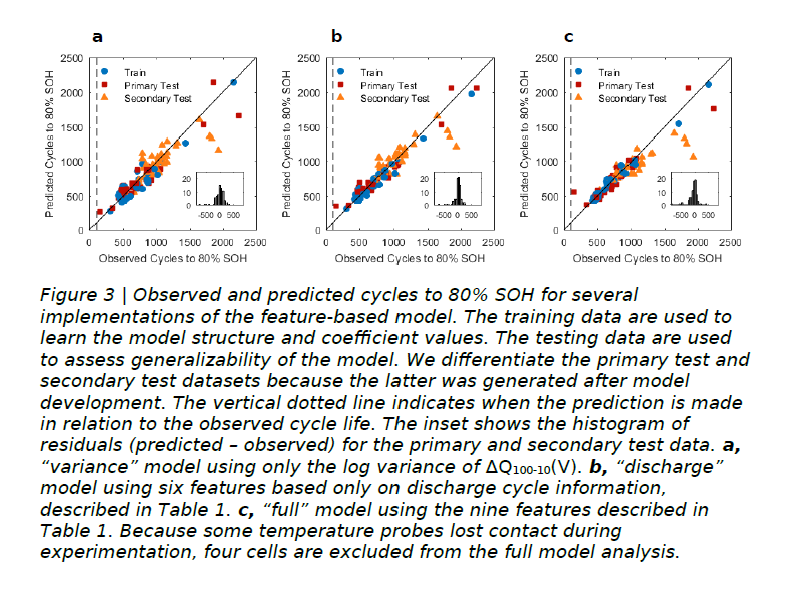

1e-05
0.9


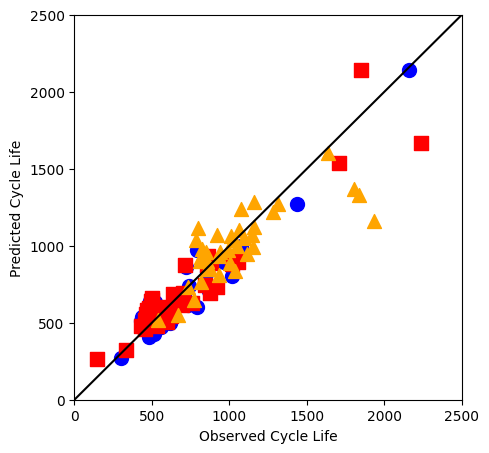

0.00795
0.9


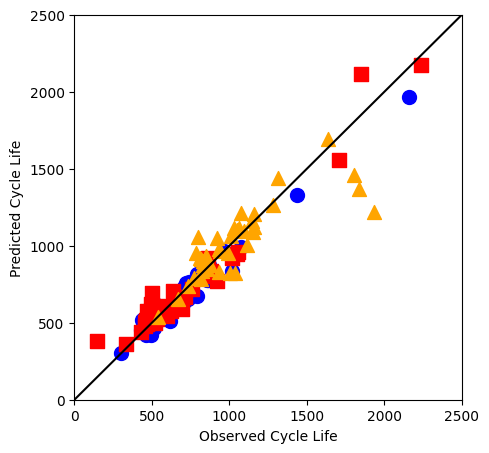

6e-05
0.9


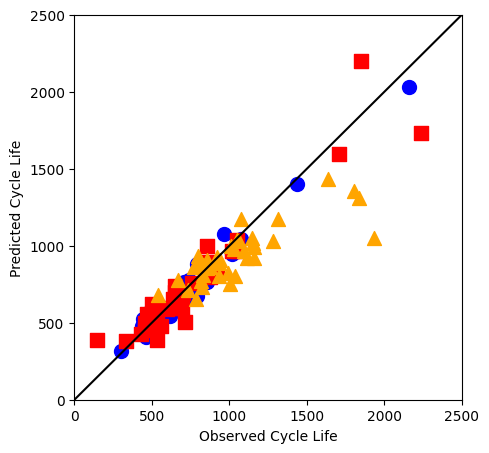

In [26]:
import warnings
warnings.filterwarnings('ignore')

var_rmse,var_mpe=mod(varmod_features,target_features,var_params,'Variance_Model.jpeg')
dis_rmse,dis_mpe=mod(dismod_features,target_features,dis_paras,'Discharge_Model.jpeg')
full_rmse,full_mpe=mod(full_features,target_features,full_params,'Full_Model.jpeg')

In [27]:
pd.DataFrame({"Model":["Variance model", "Discharge model", "Full model"],
              "RMSE - Train": [var_rmse[0],dis_rmse[0],full_rmse[0]],
              "RMSE - Primary test": [var_rmse[1],dis_rmse[1],full_rmse[1]],
              "RMSE - Secondary test": [var_rmse[2],dis_rmse[2],full_rmse[2]],
              "MPE - Train": [var_mpe[0],dis_mpe[0],full_mpe[0]],
              "MPE - Primary test": [var_mpe[1],dis_mpe[1],full_mpe[1]],
              "MPE - Secondary test": [var_mpe[2],dis_mpe[2],full_mpe[2]]})                                                                       

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test
0,Variance model,103.6,137.9,195.9,14.1,14.7,11.4
1,Discharge model,75.8,90.5,170.4,9.8,13.4,8.8
2,Full model,55.7,121.8,214.0,6.7,12.3,11.9


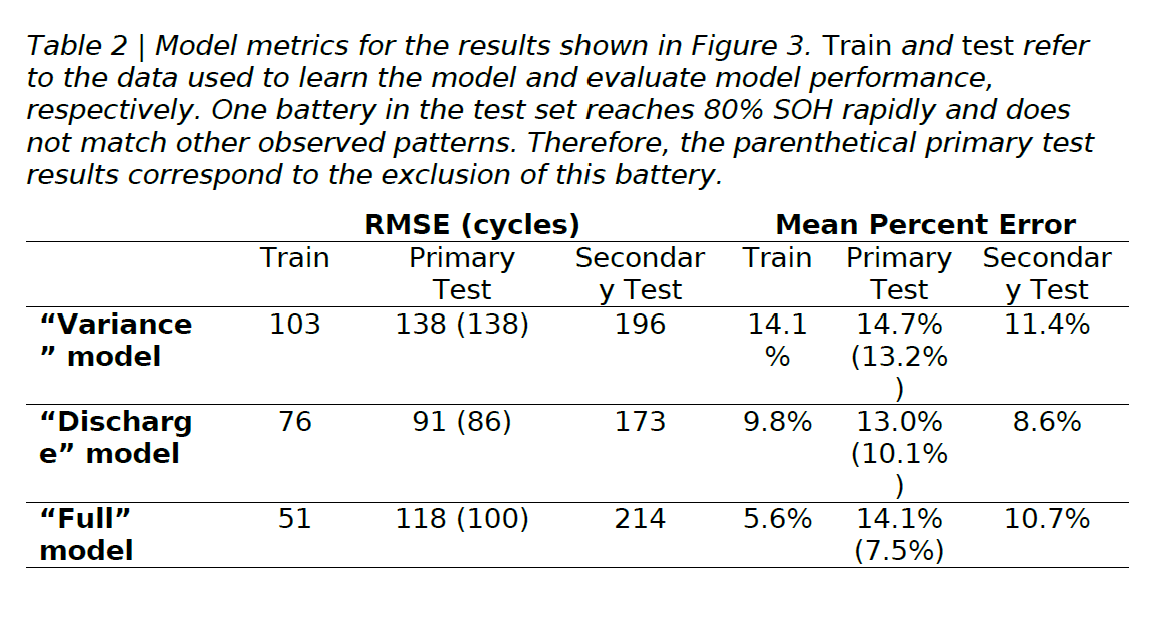